# Tutorial 4 SpatialEx+ Enables Spatial Multi-omics through Omics Diagonal Integration (transcriptomics-proteomics)

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import preprocess as pp
from utils import Estimate_boundary

## 1. Train model

In [2]:
!python omics_diagonal_integration_rna_protein.py --device 3

Namespace(activation='elu', alpha_l=2, attn_drop=0.1, batch_size=4096, beta_l=1, cell_diameter=-1, cluster_label='', decoder='linear', deg4feat=False, device=3, drop_edge_rate=0.0, encoder='hgnn', epoch=500, graph_kind='spatial', h5_path1='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5', h5_path2='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cell_protein_matrix.h5ad', hidden_dim=512, image_encoder='uni', img_batch_size=64, img_path1='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif', img_path2='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='mse', lr=0.001, mask_gene_rate=0.8, negative_slope=0.2, nei_radius=7, norm='batchnorm', num_classes=8, num_features=3000, num_heads=4, num_layers=2, num_neighbors=7, num_out_heads=1, obs_path1='/home/wcy/code/da

## 2. Read in reference: cell_coors, inner_coors, H&E images 

In [3]:
obs1 = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/HBRC_Rep1_cell_coor.csv', index_col=0)
obs2 = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/HBRC_Rep2_cell_coor.csv', index_col=0)
ref1 = sc.read_h5ad('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/Human_Breast_Cancer_Rep1_uni_resolution64_full.h5ad')
ref2 = sc.read_h5ad('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/Human_Breast_Cancer_Rep2_uni_resolution64_full.h5ad')
ref1, ref2

(AnnData object with n_obs × n_vars = 164000 × 313
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'image_col', 'image_row', 'spot'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'log1p'
     obsm: 'he', 'image_coor', 'spatial'
     layers: 'raw',
 AnnData object with n_obs × n_vars = 111555 × 313
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'image_col', 'image_row', 'spot'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'log1p'
     obsm: 'he', 'image_coor', 'spatial'
     layers: 'raw')

(3078, 2424) 0.1
(2424, 3078, 3)


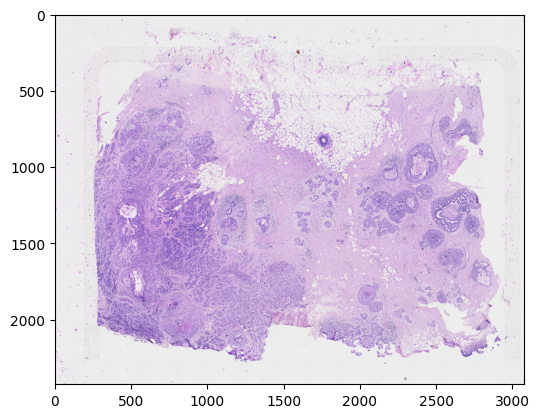

In [4]:
img_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img, scale = pp.Read_HE_image(img_path)

scale_factor = 0.1                 # 缩小图像加速可视化
target_size = (int(img.shape[1]*scale_factor), int(img.shape[0]*scale_factor))
print(target_size, scale_factor)

img_resized1 = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
print(img_resized1.shape)
plt.imshow(img_resized1)
plt.show()

(3078, 1987) 0.1
(1987, 3078, 3)


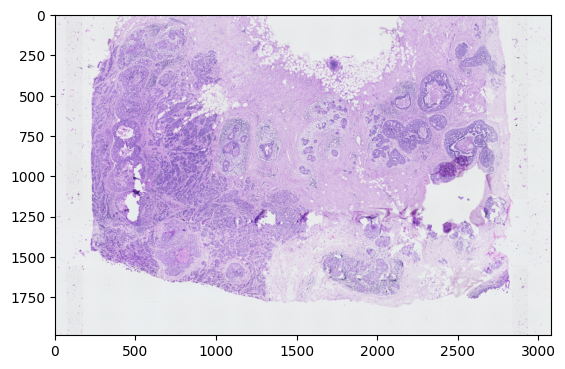

In [5]:
img_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
img, scale = pp.Read_HE_image(img_path)

scale_factor = 0.1
target_size = (int(img.shape[1]*scale_factor), int(img.shape[0]*scale_factor))
print(target_size, scale_factor)

img_resized2 = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
print(img_resized2.shape)
plt.imshow(img_resized2)
plt.show()

## 3. Visualize proteins

### 3.1 Measured expression

In [6]:
adata_protein = sc.read_h5ad('/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cell_protein_matrix.h5ad')
adata_protein.var_names = adata_protein.var_names.astype(str)
adata_protein.obs_names = adata_protein.obs_names.astype(str)
obs = pd.read_csv('/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cells.csv', index_col=0)
obs.index = obs.index.astype(str)
adata_protein = adata_protein[obs.index]
adata_protein.obs = obs
adata_protein.obsm['spatial'] = adata_protein.obs[['x_centroid', 'y_centroid']].values
adata_protein.var_names_make_unique()
adata_protein = adata_protein[ref1.obs_names]
sc.pp.scale(adata_protein)

trans_mtx = pd.read_csv("/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv", header=None).values
adata_protein = pp.Register_physical_to_pixel(adata_protein, trans_mtx, scale)
adata_protein

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 164000 × 2
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'image_col', 'image_row'
    var: 'mean', 'std'
    obsm: 'spatial', 'image_coor'

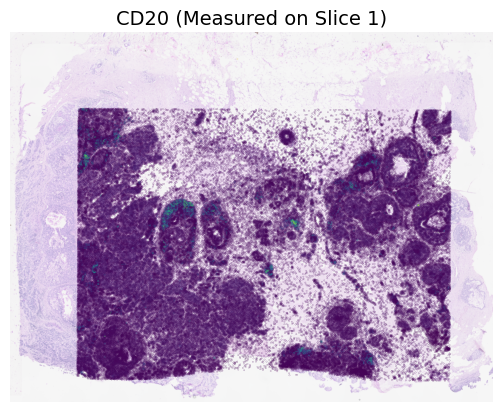

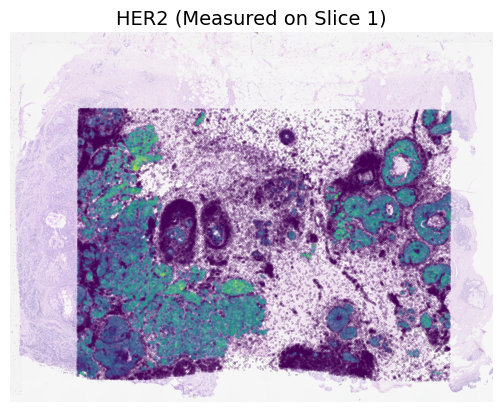

In [7]:
plt.imshow(img_resized1, alpha=0.5)
x, y = adata_protein.obsm['image_coor'][:, 0]//10, adata_protein.obsm['image_coor'][:, 1]//10
plt.scatter(x, y, c=adata_protein[:,'CD20'].X, s=0.01)
plt.xlim(225, 2900)
plt.ylim(250, 2300)
plt.axis('off')
ax = plt.gca()
ax.invert_yaxis()
plt.title('CD20 (Measured on Slice 1)', fontsize=14)
plt.show()

plt.imshow(img_resized1, alpha=0.5)
x, y = adata_protein.obsm['image_coor'][:, 0]//10, adata_protein.obsm['image_coor'][:, 1]//10
plt.scatter(x, y, c=adata_protein[:,'HER2'].X, s=0.01)
plt.xlim(225, 2900)
plt.ylim(250, 2300)
plt.axis('off')
ax = plt.gca()
ax.invert_yaxis()
plt.title('HER2 (Measured on Slice 1)', fontsize=14)
plt.show()

### 3.1 SpatialEx+ expands the expression to the whole slide image wide

Estimating y boundary


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1890.60it/s]


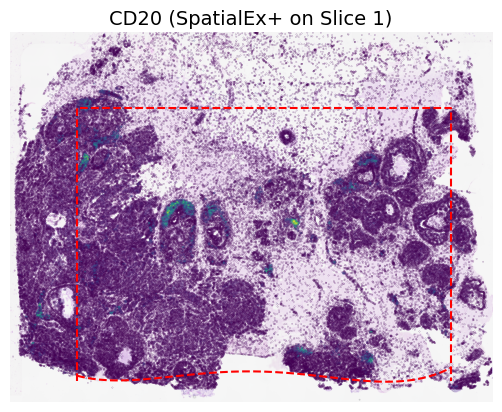

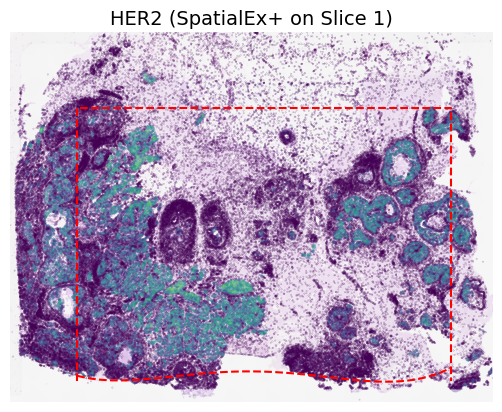

In [8]:
protein1_outer = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tuotrial3/outer_protein_1.csv', index_col=0)

x, y = ref1.obsm['image_coor'][:, 0]//10, ref1.obsm['image_coor'][:, 1]//10
xmin, ymin = x.min(), y.min()
xmax, ymax = x.max(), y.max()
boundary_func, y_estimate = Estimate_boundary(x, y)
x, y = obs1['image_col'].values, obs1['image_row'].values
y_boundary = boundary_func(np.arange(xmin, xmax))

plt.imshow(img_resized1, alpha=0.5)
plt.plot([xmin, xmin, xmax, xmax], [ymax, ymin, ymin, ymax], linestyle='--', c='red')
plt.plot(np.arange(xmin, xmax), y_boundary, linestyle='--', c='red')

x, y = obs1['image_col'].values//10, obs1['image_row'].values//10
plt.scatter(x, y, c=protein1_outer['CD20'], vmin=0, vmax=8, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(225, 2900)
plt.ylim(250, 2300)
ax.invert_yaxis()
plt.title('CD20 (SpatialEx+ on Slice 1)', fontsize=14)
plt.show()

plt.imshow(img_resized1, alpha=0.5)
plt.plot([xmin, xmin, xmax, xmax], [ymax, ymin, ymin, ymax], linestyle='--', c='red')
plt.plot(np.arange(xmin, xmax), y_boundary, linestyle='--', c='red')

x, y = obs1['image_col'].values//10, obs1['image_row'].values//10
plt.scatter(x, y, c=protein1_outer['HER2'], vmin=0, vmax=3, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(225, 2900)
plt.ylim(250, 2300)
ax.invert_yaxis()
plt.title('HER2 (SpatialEx+ on Slice 1)', fontsize=14)
plt.show()

### 3.3 SpatialEx+ impute the expression of proteins on the other slice

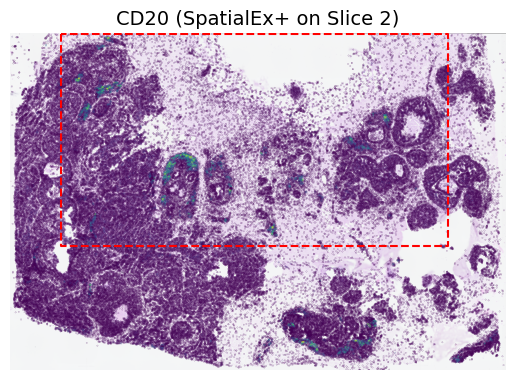

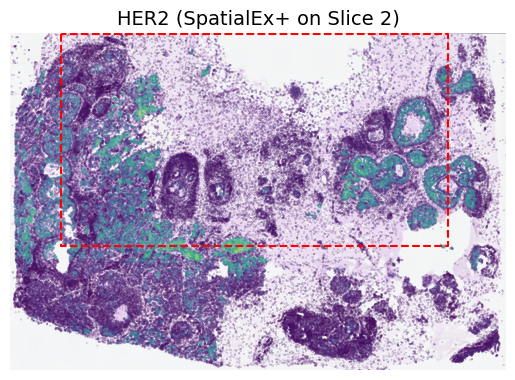

In [9]:
protein2_outer = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tuotrial3/outer_protein_2.csv', index_col=0)

plt.imshow(img_resized2, alpha=0.5)
x, y = ref2.obs['image_col'].values//10, ref2.obs['image_row'].values//10
xmin, ymin = x.min(), y.min()
xmax, ymax = x.max(), y.max()
plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], linestyle='--', c='red')

y, x = obs2['image_col'].values//10, obs2['image_row'].values//10
plt.scatter(x, y, c=protein2_outer['CD20'], vmin=0, vmax=6, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(200, 2850)
plt.ylim(0, 1800)
ax.invert_yaxis()
plt.title('CD20 (SpatialEx+ on Slice 2)', fontsize=14)
plt.show()

plt.imshow(img_resized2, alpha=0.5)
y, x = obs2['image_col'].values//10, obs2['image_row'].values//10
plt.scatter(x, y, c=protein2_outer['HER2'], vmin=-0.3, s=0.01)
plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], linestyle='--', c='red')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(200, 2850)
plt.ylim(0, 1800)
ax.invert_yaxis()
plt.title('HER2 (SpatialEx+ on Slice 2)', fontsize=14)
plt.show()

## 4. Visualize the gene expression

### 4.1 Measured expression

In [10]:
h5_path2 = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path2 = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cells.csv'
adata_rna = pp.Read_Xenium(h5_path2, obs_path2)
adata_rna = pp.Preprocess_adata(adata_rna)
adata_rna = adata_rna[ref2.obs_names]
adata_rna.obsm['image_coor'] = ref2.obsm['image_coor']
adata_rna

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 111555 × 313
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial', 'image_coor'
    layers: 'raw'

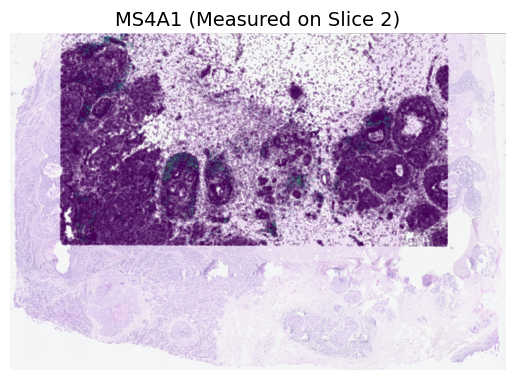

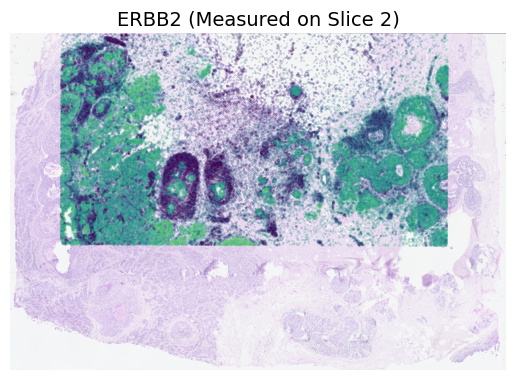

In [11]:
plt.imshow(img_resized2, alpha=0.5)
x, y = adata_rna.obsm['image_coor'][:, 0]//10, adata_rna.obsm['image_coor'][:, 1]//10
plt.scatter(x, y, c=adata_rna[:,'MS4A1'].X, s=0.01)
plt.xlim(200, 2850)
plt.ylim(0, 1800)
plt.axis('off')
ax = plt.gca()
ax.invert_yaxis()
plt.title('MS4A1 (Measured on Slice 2)', fontsize=14)
plt.show()

plt.imshow(img_resized2, alpha=0.5)
x, y = adata_rna.obsm['image_coor'][:, 0]//10, adata_rna.obsm['image_coor'][:, 1]//10
plt.scatter(x, y, c=adata_rna[:,'ERBB2'].X, s=0.01)
plt.xlim(200, 2850)
plt.ylim(0, 1800)
plt.axis('off')
ax = plt.gca()
ax.invert_yaxis()
plt.title('ERBB2 (Measured on Slice 2)', fontsize=14)
plt.show()

### 4.1 SpatialEx+ expands the gene expression to the whole slide image wide

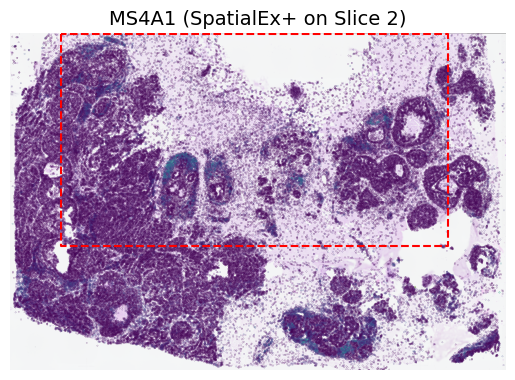

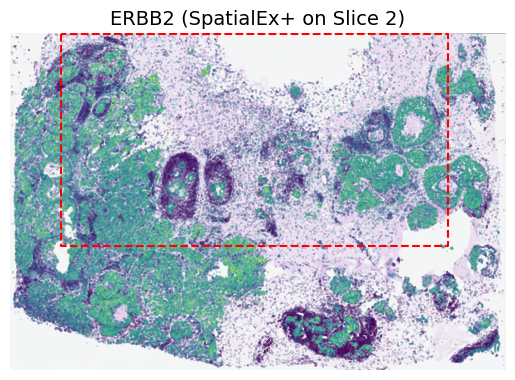

In [12]:
rna2_outer = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tuotrial3/outer_rna_2.csv', index_col=0)

plt.imshow(img_resized2, alpha=0.5)
x, y = ref2.obs['image_col'].values//10, ref2.obs['image_row'].values//10
xmin, ymin = x.min(), y.min()
xmax, ymax = x.max(), y.max()
plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], linestyle='--', c='red')

y, x = obs2['image_col'].values//10, obs2['image_row'].values//10
plt.scatter(x, y, c=rna2_outer['MS4A1'], vmin=0, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(200, 2850)
plt.ylim(0, 1800)
ax.invert_yaxis()
plt.title('MS4A1 (SpatialEx+ on Slice 2)', fontsize=14)
plt.show()

plt.imshow(img_resized2, alpha=0.5)
y, x = obs2['image_col'].values//10, obs2['image_row'].values//10
plt.scatter(x, y, c=rna2_outer['ERBB2'], vmin=0, vmax=4.5, s=0.01)
plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], linestyle='--', c='red')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(200, 2850)
plt.ylim(0, 1800)
ax.invert_yaxis()
plt.title('ERBB2 (SpatialEx+ on Slice 2)', fontsize=14)
plt.show()

### 4.2 SpatialEx+ impute the gene expression on the other slice

Estimating y boundary


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3345.01it/s]


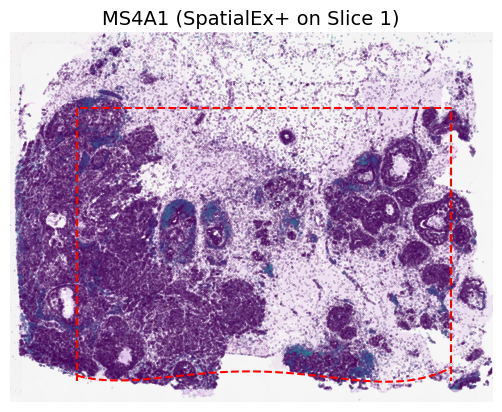

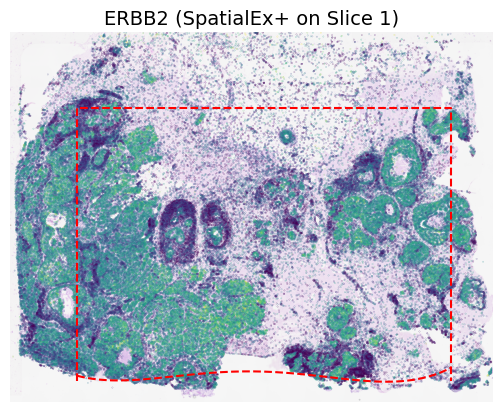

In [13]:
rna1_outer = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tuotrial3/outer_rna_1.csv', index_col=0)

x, y = ref1.obsm['image_coor'][:, 0]//10, ref1.obsm['image_coor'][:, 1]//10
xmin, ymin = x.min(), y.min()
xmax, ymax = x.max(), y.max()
boundary_func, y_estimate = Estimate_boundary(x, y)
x, y = obs1['image_col'].values, obs1['image_row'].values
y_boundary = boundary_func(np.arange(xmin, xmax))

plt.imshow(img_resized1, alpha=0.5)
plt.plot([xmin, xmin, xmax, xmax], [ymax, ymin, ymin, ymax], linestyle='--', c='red')
plt.plot(np.arange(xmin, xmax), y_boundary, linestyle='--', c='red')

x, y = obs1['image_col'].values//10, obs1['image_row'].values//10
plt.scatter(x, y, c=rna1_outer['MS4A1'], vmin=0, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(225, 2900)
plt.ylim(250, 2300)
ax.invert_yaxis()
plt.title('MS4A1 (SpatialEx+ on Slice 1)', fontsize=14)
plt.show()

plt.imshow(img_resized1, alpha=0.5)
plt.plot([xmin, xmin, xmax, xmax], [ymax, ymin, ymin, ymax], linestyle='--', c='red')
plt.plot(np.arange(xmin, xmax), y_boundary, linestyle='--', c='red')

x, y = obs1['image_col'].values//10, obs1['image_row'].values//10
plt.scatter(x, y, c=rna1_outer['ERBB2'], vmin=0.2, vmax=4.8, s=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.xlim(225, 2900)
plt.ylim(250, 2300)
ax.invert_yaxis()
plt.title('ERBB2 (SpatialEx+ on Slice 1)', fontsize=14)
plt.show()